# League of Legends Item Balancing

### Capstone Project 1: In-Depth Analysis

This section will be for some final statistical analyses and some machine learning models to help me understand the influence of various item attributes on an item's win rate and pick rate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import seaborn as sns
%matplotlib inline

sns.set()

In [2]:
matches_df = pd.read_csv('../data/match_data_2.csv', encoding='utf-8', index_col=0)
matches_df.reset_index(drop=True, inplace=True)

champions_min_df = pd.read_csv('../data/champions_min_8.22.1.csv', encoding='utf-8', index_col=0)

items_df = pd.read_csv('../data/items.8.22.1.csv', encoding='utf-8', index_col=0)
items_df['tags'] = [re.findall('[A-Za-z]\w*', items_df.loc[item_id, 'tags']) for item_id in items_df.index]

item_occ = pd.read_csv('../data/item_occurrences_8.22.1.csv', encoding='utf-8', index_col=0)
item_occ['tags'] = items_df['tags']
item_occ = item_occ.join(items_df[['name', 'full_item', 'total_gold']])

tag_based_stats_df = pd.read_csv('../data/tag_based_stats_8.22.1.csv', encoding='utf-8', index_col=0)

timing_df = pd.read_csv('../data/item_timing_8.22.1.csv', encoding='utf-8', index_col=0)

Most of the raw data I intend to use is in the Match dataframe.

Here is a sample of it.

In [3]:
matches_df.loc[:,'stats.item0':'stats.item6'].head(10)

,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6
0,3020,3152,3285,0,1026,3157,3340
1,3117,3107,3092,3024,1029,1029,3340
2,1416,3078,3047,3748,0,0,3340
3,3020,3285,3157,3135,3165,2139,3340
4,3078,3047,3053,3133,0,0,3340
5,2033,3147,3047,3071,3036,3155,3340
6,3155,3095,3031,3006,3094,3072,3340
7,3020,3285,3157,1058,3116,0,3340
8,3401,3190,3107,3117,1029,1029,3364
9,3156,1400,3053,3047,3071,1029,3340


The other important dataframe has descriptive statistics for each item, and some identifiers from the Items table.

In [4]:
item_occ.tail()

,count,pick_rate,spread,wins,win_rate,tags,name,full_item,total_gold
item_id,,,,,,,,,
3812,177,0.019135,36,106.0,0.598870,"[Damage, LifeSteal, CooldownReduction]",Death's Dance,True,3500.0
3814,48,0.005189,16,26.0,0.541667,"[Health, Damage, Active, ArmorPenetration]",Edge of Night,True,3000.0
3905,96,0.010378,29,46.0,0.479167,"[SpellDamage, Active, CooldownReduction, Slow,...",Twin Shadows,True,2400.0
3907,69,0.007459,28,43.0,0.623188,"[SpellDamage, Active, NonbootsMovement]",Spellbinder,True,2900.0
3916,159,0.017189,48,82.0,0.515723,"[Health, MagicPenetration, SpellDamage]",Oblivion Orb,False,1500.0


One of the best-visualized results from my EDA was the graph of win-rate outliers.

<img src='../analysis_images/win_rate_diff_abnormal.png'>

However, I realized there is an interesting noise that can mask the correlation between balance and win rate.

It involves the pick rate. In essence, if the same item is built on both teams, one of them is guaranteed to win, and one to lose, and so the win rate for that item drifts towards 0.50. The figure below illustrates this.

<img src='../analysis_images/full_item_win_rate_vs_pick_rate.png'>

The first step I would like to take in this analysis is to examine this problem more closely. 

I need to check the win rate of each item ONLY in games when there are more of the item built on one team than the other.

In [5]:
# Function to get the unmasked number of game results for each item
# For a game and an item, check how many of the item each team built
# For the team with the higher number of purchases of that item
# Return their win result as many times as they built the item in excess of the other team

# game_num should start at 0

def unmask_item_wins(game_num, item_id):
    # Inside the match dataframe
    # Each game is sequential
    # Each team is grouped together
    
    if (game_num > len(matches_df) / 10):
        raise ValueError('Game number is out of bounds.\
                          There are not that many games.')
    
    team_1_item_count = 0
    team_2_item_count = 0
    
    # See how many of the item each team built
    team_1_items = matches_df.loc[10 * game_num : 10 * game_num + 4,
                                  'stats.item0' : 'stats.item6']\
                              .stack().reset_index(drop=True).value_counts()
    
    team_2_items = matches_df.loc[10 * game_num + 5: 10 * game_num + 9,
                                  'stats.item0' : 'stats.item6']\
                             .stack().reset_index(drop=True).value_counts()
    
    # Check to make sure the requested item was built at all
    if (item_id in team_1_items):
        team_1_item_count = team_1_items[item_id]
    
    if (item_id in team_2_items):
        team_2_item_count = team_2_items[item_id]
    
    if (team_1_item_count + team_2_item_count == 0):
        return []
    
    # Logic to return the proper value based on who won the game
    team_1_win = matches_df.loc[10 * game_num, 'stats.win']
    team_2_win = matches_df.loc[10 * game_num + 5, 'stats.win']
    
    results = []
    
    # Want to return the game result for each item in excess of the other team
    if (team_1_item_count > team_2_item_count):
        results = [team_1_win for _ in range(team_1_item_count - team_2_item_count)]
    
    if (team_1_item_count < team_2_item_count):
        results = [team_2_win for _ in range(team_2_item_count - team_1_item_count)]
        
    return results

Now that this loop has been run, I don't need to run it again (since I saved the table). It takes about 10 minutes, uses only a little RAM, and about 30% of my CPU.

In [6]:
# Loop to find unmasked match results
# Will attach average win rate and std win rate to items_df

for item_id in item_occ.index.values:
    item_wins_unmasked = []
    
    # Get match results
    for match in range(len(matches_df) / 10):
        item_wins_unmasked.append(unmask_item_wins(match, item_id))
    
    # Concatenate results
    # for match wins in item_wins_unmasked
    #     for result in match wins
    #         append(result)
    item_wins_unmasked = [result for match_wins in item_wins_unmasked for result in match_wins]
    count = len(item_wins_unmasked)
    mean = np.mean(item_wins_unmasked) if count != 0 else 0
    std = np.sqrt(mean * (1 - mean) / count) if count != 0 else 0
    
    item_occ.loc[item_id, 'count_unmasked'] = count
    item_occ.loc[item_id, 'wr_unmasked'] = mean
    item_occ.loc[item_id, 'wr_std_unmasked'] = std

In [7]:
item_occ.to_csv('../data/item_statistics_8.22.1.csv', encoding='utf-8')

In [8]:
item_occ = pd.read_csv('../data/item_statistics_8.22.1.csv', encoding='utf-8', index_col=0)
item_occ['tags'] = items_df['tags']

Now that I've updated the item statistics dataframe, lets compare the win rate and the "unmasked" win rate as functions of pick rate.

Let's recall that we want to avoid some kinds of items.

In [9]:
consumable = [True if (type(tags) == list and 'Consumable' in tags) else False for tags in item_occ['tags']]

lane_items = [True if (type(tags) == list and 'Lane' in tags) else False for tags in item_occ['tags']]

boots = [True if (type(tags) == list and 'Boots' in tags) else False for tags in item_occ['tags']]

trinkets = [True if (type(tags) == list and 'Trinket' in tags) else False for tags in item_occ['tags']]

other_no_no_ids = [2010, 2057, 2403]
other_edge_cases = [True if id in other_no_no_ids else False for id in item_occ.reset_index()['item_id']]

edge_cases = [cons or lane or other or boot or trinket for cons, lane, other, boot, trinket in
              zip(consumable, lane_items, other_edge_cases, boots, trinkets)]
no_edge_cases = [not case for case in edge_cases]

In [10]:
full_items_df = item_occ[(item_occ['full_item'] == True) &
                         (no_edge_cases) &
                         (item_occ['count'] > 10)]

full_item_avg_win_rate = (full_items_df['win_rate'] *\
                          full_items_df['count']).sum()\
                              / full_items_df['count'].sum()

full_item_avg_wr_unmasked = (full_items_df['wr_unmasked'] *\
                             full_items_df['count_unmasked']).sum()\
                                 / full_items_df['count_unmasked'].sum()
print("Average Win Rate for Full Items Across all Games:", full_item_avg_win_rate)
print("Average Win Rate for Full Items Over Games Without Even Item Counts", full_item_avg_wr_unmasked)

('Average Win Rate for Full Items Across all Games:', 0.54733688708758366)
('Average Win Rate for Full Items Over Games Without Even Item Counts', 0.56297989566848949)


Here is the plot from before, Item Win Rates with the aforementioned masking.

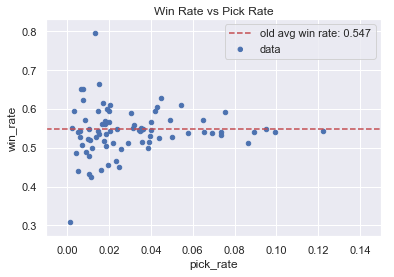

In [11]:
full_items_df.plot('pick_rate', 'win_rate', kind='scatter',
                   xlim=[-0.01, 0.15], label='data',
                   title='Win Rate vs Pick Rate')

plt.plot(np.linspace(-0.01, 0.15, 50), np.full(50, full_item_avg_win_rate),
         'r--', label='old avg win rate: 0.547')
plt.legend()

And here are the Item Win Rates unmasked.

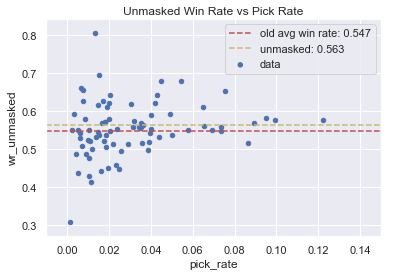

In [12]:
full_items_df.plot('pick_rate', 'wr_unmasked', kind='scatter',
                   xlim=[-0.01, 0.15], label='data',
                   title='Unmasked Win Rate vs Pick Rate')

plt.plot(np.linspace(-0.01, 0.15, 50), np.full(50, full_item_avg_win_rate),
         'r--', label='old avg win rate: 0.547')
plt.plot(np.linspace(-0.01, 0.15, 50), np.full(50, full_item_avg_wr_unmasked),
         'y--', label='unmasked: 0.563')
plt.legend()
plt.savefig('../analysis_images/um_win_rate_vs_pick_rate.png')

In [13]:
full_items_df['unmasking_diff'] = full_items_df['wr_unmasked'] - full_items_df['win_rate']

C:\Users\sebia\Miniconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


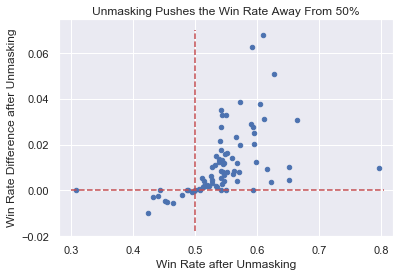

In [14]:
full_items_df.plot(x='win_rate', y='unmasking_diff', kind='scatter',
                  title='Unmasking Pushes the Win Rate Away From 50%',
                  xlim=[0.28, 0.82], ylim=[-0.02, 0.075])

plt.ylabel('Win Rate Difference after Unmasking')
plt.xlabel('Win Rate after Unmasking')

plt.plot(np.linspace(0.3, 0.805, 50), np.full(50, 0.0), 'r--')
plt.plot(np.full(50, 0.5), np.linspace(-0.0175, 0.07), 'r--')
plt.savefig('../analysis_images/win_rate_unmasking.png')

As expected, the unmasking pushed win rates away from 0.50, since the masking drew win rates into 0.50.

Let's remake the plot of win rate outliers and see if it's different now.

In [15]:
wr_stats_df = item_occ[['count', 'pick_rate', 'spread', 'wins', 'win_rate',
                        'count_unmasked', 'wr_unmasked', 'wr_std_unmasked',
                        'full_item', 'name', 'total_gold', 'tags']]

wr_stats_df.loc[:, 'wr_diff'] = wr_stats_df['win_rate'] - full_item_avg_win_rate
wr_stats_df.loc[:, 'wr_std'] = np.sqrt(full_item_avg_win_rate * (1 - full_item_avg_win_rate) 
                                / wr_stats_df['count'])
wr_stats_df.loc[:, 'CI95'] = wr_stats_df['wr_std'] * 1.96

wr_stats_df.loc[:, 'wr_um_diff'] = wr_stats_df['wr_unmasked'] - full_item_avg_wr_unmasked
wr_stats_df.loc[:, 'CI95_um'] = wr_stats_df['wr_std_unmasked'] * 1.96

C:\Users\sebia\Miniconda2\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sebia\Miniconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
wr_stats_df.head()

,count,pick_rate,spread,wins,win_rate,count_unmasked,wr_unmasked,wr_std_unmasked,full_item,name,total_gold,tags,wr_diff,wr_std,CI95,wr_um_diff,CI95_um
item_id,,,,,,,,,,,,,,,,,
0,5659,0.611784,141,2400.0,0.424103,1751.0,0.254712,0.010412,NaN,NaN,NaN,NaN,-0.123234,0.006617,0.012969,-0.308268,0.020408
1001,459,0.049622,113,159.0,0.346405,297.0,0.262626,0.025535,False,Boots of Speed,300.0,[Boots],-0.200932,0.023233,0.045537,-0.300354,0.050048
1004,78,0.008432,23,28.0,0.358974,70.0,0.342857,0.056733,False,Faerie Charm,125.0,[ManaRegen],-0.188363,0.056360,0.110465,-0.220123,0.111197
1006,46,0.004973,27,18.0,0.391304,42.0,0.380952,0.074933,False,Rejuvenation Bead,150.0,[HealthRegen],-0.156033,0.073390,0.143844,-0.182028,0.146869
1011,269,0.029081,70,129.0,0.479554,235.0,0.476596,0.032581,False,Giant's Belt,1000.0,[Health],-0.067783,0.030349,0.059483,-0.086384,0.063858


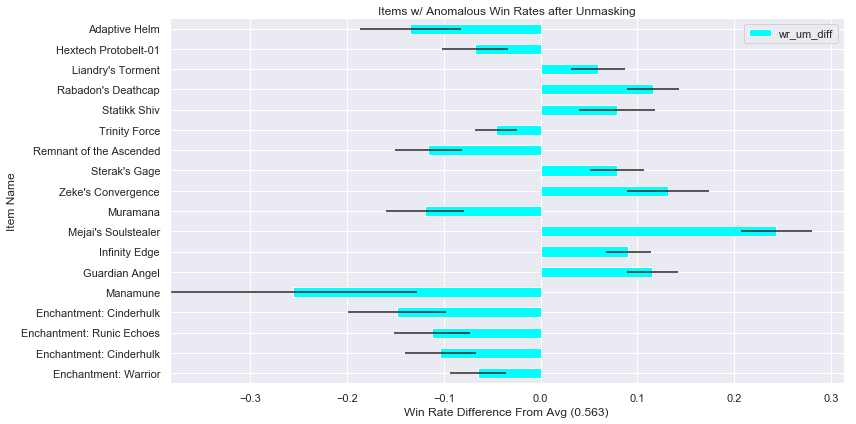

In [17]:
plt.rcParams["figure.figsize"] = (12, 6)
wr_stats_df[(wr_stats_df['full_item'] == True) &
            (no_edge_cases) &
            (wr_stats_df['count_unmasked'] > 10) &
            (wr_stats_df['wr_um_diff'].abs() > wr_stats_df['CI95_um'])
           ].plot(y='wr_um_diff', x='name', kind='barh',
                        xerr='wr_std_unmasked', color='cyan',
                        title='Items w/ Anomalous Win Rates after Unmasking')

plt.xlabel('Win Rate Difference From Avg (0.563)')
plt.ylabel('Item Name')
plt.tight_layout()
plt.savefig('../analysis_images/wr_diff_unmasked_abnormal.png')

In [18]:
wr_stats_df[(wr_stats_df['full_item'] == True) &
            (no_edge_cases) &
            (wr_stats_df['count_unmasked'] > 10) &
            (wr_stats_df['wr_um_diff'].abs() > wr_stats_df['CI95_um'])
           ]

,count,pick_rate,spread,wins,win_rate,count_unmasked,wr_unmasked,wr_std_unmasked,full_item,name,total_gold,tags,wr_diff,wr_std,CI95,wr_um_diff,CI95_um
item_id,,,,,,,,,,,,,,,,,
1400,359,0.038811,23,179.0,0.498607,295.0,0.498305,0.029111,True,Enchantment: Warrior,2625.0,[],-0.048730,0.026270,0.051490,-0.064675,0.057057
1401,215,0.023243,26,100.0,0.465116,185.0,0.459459,0.036640,True,Enchantment: Cinderhulk,2500.0,[],-0.082221,0.033947,0.066535,-0.103520,0.071814
1402,180,0.019459,23,82.0,0.455556,162.0,0.450617,0.039092,True,Enchantment: Runic Echoes,2625.0,[],-0.091781,0.037100,0.072717,-0.112363,0.076620
1413,106,0.011459,22,45.0,0.424528,94.0,0.414894,0.050819,True,Enchantment: Cinderhulk,2500.0,[],-0.122809,0.048346,0.094758,-0.148086,0.099604
3004,13,0.001405,3,4.0,0.307692,13.0,0.307692,0.128008,True,Manamune,2400.0,"[Damage, Mana, ManaRegen, OnHit]",-0.239645,0.138052,0.270582,-0.255288,0.250895
3026,503,0.054378,60,307.0,0.610338,311.0,0.678457,0.026485,True,Guardian Angel,2800.0,"[Armor, Damage]",0.063001,0.022194,0.043500,0.115477,0.051911
3031,697,0.075351,25,412.0,0.591105,413.0,0.653753,0.023411,True,Infinity Edge,3400.0,"[CriticalStrike, Damage]",0.043768,0.018854,0.036953,0.090773,0.045886
3041,123,0.013297,45,98.0,0.796748,119.0,0.806723,0.036198,True,Mejai's Soulstealer,1400.0,"[SpellDamage, Mana]",0.249411,0.044881,0.087967,0.243743,0.070947
3042,151,0.016324,4,67.0,0.443709,151.0,0.443709,0.040431,True,Muramana,2400.0,[OnHit],-0.103628,0.040507,0.079393,-0.119271,0.079244


From the first win rate abnormality plot, the suspect items were (in order of win rate abnormality) (the average win rate occurs between Infinity Edge and Trinity Force):

In [19]:
abnormal_items = wr_stats_df[(wr_stats_df['full_item'] == True) &
                             (no_edge_cases) &
                             (wr_stats_df['count'] > 10) &
                             (wr_stats_df['wr_diff'].abs() > wr_stats_df['CI95'])
                            ].sort_values('wr_diff', ascending=False)['name']
abnormal_items

item_id
3041          Mejai's Soulstealer
3050           Zeke's Convergence
3089           Rabadon's Deathcap
3026               Guardian Angel
3053                Sterak's Gage
3031                Infinity Edge
3078                Trinity Force
1401      Enchantment: Cinderhulk
1402    Enchantment: Runic Echoes
3069      Remnant of the Ascended
3042                     Muramana
3194                Adaptive Helm
1413      Enchantment: Cinderhulk
Name: name, dtype: object

This second check on win rate has found the following items (in order of win rate abnormality) (the average win rate occurs between Liandry's Torment and Trinity Force):

In [20]:
abnormal_items_um = wr_stats_df[(wr_stats_df['full_item'] == True) &
                                (no_edge_cases) &
                                (wr_stats_df['count_unmasked'] > 10) &
                                (wr_stats_df['wr_um_diff'].abs() > wr_stats_df['CI95_um'])
                               ].sort_values('wr_um_diff', ascending=False)['name']
abnormal_items_um

item_id
3041          Mejai's Soulstealer
3050           Zeke's Convergence
3089           Rabadon's Deathcap
3026               Guardian Angel
3031                Infinity Edge
3087                 Statikk Shiv
3053                Sterak's Gage
3151            Liandry's Torment
3078                Trinity Force
1400         Enchantment: Warrior
3152         Hextech Protobelt-01
1401      Enchantment: Cinderhulk
1402    Enchantment: Runic Echoes
3069      Remnant of the Ascended
3042                     Muramana
3194                Adaptive Helm
1413      Enchantment: Cinderhulk
3004                     Manamune
Name: name, dtype: object

Item ID / Smite colors:

1400 / Blue

1401 / Blue

1402 / Blue

1413 / Red

1419 / Red

The following items were found only via the unmasking.

In [21]:
print(abnormal_items_um[abnormal_items_um.isin(abnormal_items) == False])

item_id
3087            Statikk Shiv
3151       Liandry's Torment
1400    Enchantment: Warrior
3152    Hextech Protobelt-01
3004                Manamune
Name: name, dtype: object


## Machine Learning Time

Make sure the data is split with test_train_split.

Import your classifiers as well.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Analysis 0: Simple Random Forest
Make a table of win/loss and individual items by splitting the match data so each item a player has built takes its own row.

Call the item_id a categorical variable, and then run a random forest algorithm. Do a version with all the items and a version with only the final items.

This basic use of random forest should bring out results similar to my statistical analyses.

In [23]:
# Only need win and item numbers
items_and_wins_df = matches_df[['stats.win', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']]

# Stack the item columns with the win boolean
item_win_sub_dfs = []
for col_name in items_and_wins_df.columns[1:]:
    sub_df = items_and_wins_df[['stats.win', col_name]]
    sub_df.columns = ['stats.win', 'item_id']
    item_win_sub_dfs.append(sub_df)
    
item_win_df = pd.concat(item_win_sub_dfs)
item_win_df.columns = ['win', 'item_id']
print(len(item_win_df))
item_win_df.head()

64750


,win,item_id
0,False,3020
1,False,3117
2,False,1416
3,False,3020
4,False,3078


In [24]:
# Matrix version of the data
X_0 = pd.get_dummies(item_win_df.item_id).values
y_0 = item_win_df.win.values

# Split the data, keeping even amounts of wins and losses in each set
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0,
                                                            test_size=0.3,
                                                            random_state=13,
                                                            stratify=y_0)

In [25]:
# Classifier
# Test against baseline, like just a Random Forest Classifier
model_0 = RandomForestClassifier(random_state=13)
# Forest Parameters
params = {'n_estimators': [5, 25, 50], 'max_depth': [None, 5, 10],
          'max_features': ['auto', 4, 7]}

# Grid Search for Best Hyperparameters
gs_forest = GridSearchCV(model_0, param_grid=params, cv=5)

Started at 4:38 PM. Finished by 5:06 PM.

Started at 5:13 PM. Finished at 5:18 PM. I removed the option for max_depth = 20, and I think that made the difference.

Started at 11:01 AM. Finished at 11:06 AM.

In [26]:
# First Pass
gs_forest.fit(X_0_train, y_0_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 25, 50], 'max_features': ['auto', 4, 7], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
gs_forest.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [28]:
gs_forest.best_score_

0.53698841698841704

In [29]:
gs_forest.cv_results_['mean_test_score']

array([ 0.53696635,  0.5368781 ,  0.53674573,  0.53698842,  0.53694429,
        0.53678985,  0.53698842,  0.53696635,  0.53681191,  0.51898511,
        0.52908991,  0.52957529,  0.50477661,  0.52847215,  0.53171539,
        0.50404854,  0.5279647 ,  0.53067843,  0.5227358 ,  0.53140651,
        0.52977386,  0.51933811,  0.53167126,  0.53325979,  0.5103144 ,
        0.52953116,  0.53189189])

In [30]:
np.mean(gs_forest.cv_results_['mean_test_score'])

0.52878919736062591

In [31]:
accuracy_score(y_0_test, gs_forest.predict(X_0_test))

0.53178893178893183

It seems like this algorithm only has a slightly better than 50% chance of predicting a game's results.

Instead of gradually increasing the data complexity, I have been recommended to go with the most reliable method.

Like a goof, I forgot to test the normal out-of-the-box classifier. Let's do that now.

In [32]:
model_0 = RandomForestClassifier(random_state=13)
model_0.fit(X_0_train, y_0_train)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [33]:
model_0.score(X_0_test, y_0_test)

0.53374517374517372

The basic random forest classifier does slightly better than the Grid Search CV version of the RF classifier.

That indicates that the classifier could perform just as well by guessing the mean, and the data isn't very good.

### Analysis : Team-wide Item Difference Random Forest

Make a table of win/loss and the difference of numbers of each item for each team as categorical variables.

This data is probably the most accurate representation of what helps teams win. Since League of Legends is a team game, your team's items and the other team's items overall are probably more important than just your own. Comparing how many of each item each team has is more likely to represent game balance.

Focusing on only the full items, not all items.

In [34]:
# Want to iterate over all games
# Have a row for each item
# Add one to a cell for each of the item a team had
team_items_df = pd.DataFrame(0, index=range(len(matches_df)/10),
                             columns=full_items_df.index.values,
                             dtype=int)
# I may want this line. I expect having 0's to predict very strongly. Maybe I don't want this line then.
team_items_df.loc[:, 0] = 0

# Match results
team_results = np.zeros(len(matches_df)/10)

This loop takes only a few seconds to run

In [35]:
# Fill dataframe
for match in range(len(matches_df)/10):
    # Result is a 0 if the first team lost, 1 if they won
    team_results[match] = matches_df.loc[10 * match, 'stats.win']
    
    # Positive # of items for first team
    # Negative # of items for second team
    team_1_items = matches_df.loc[10 * match : 10 * match + 4, 'stats.item0' : 'stats.item5']
    team_2_items = matches_df.loc[10 * match + 5 : 10 * match + 9, 'stats.item0' : 'stats.item5']
    
    # Compress into a Series
    team_1_items = team_1_items.stack().reset_index(drop=True).value_counts()
    team_2_items = team_2_items.stack().reset_index(drop=True).value_counts()
    
    # Add team 1 to dataframe, subtract team 2 from dataframe
    # Adding the series to the row of the dataframe causes NaN values anywhere the series doesn't have data
    team_items_df.loc[match, :] = (team_items_df.loc[match, :] +
                                   team_1_items.subtract(team_2_items, fill_value=0)).fillna(0)

Here is some example data where I've filtered out all of the 0 values.

In [36]:
team_items_df.loc[8,:].value_counts()

 0.0    66
-1.0    10
 1.0     4
 3.0     1
Name: 8, dtype: int64

In [37]:
row = team_items_df.iloc[8,:]
pd.DataFrame(team_items_df.loc[8,:][row != 0]).transpose()

,1402,1412,3027,3068,3069,3071,3092,3100,3153,3157,3285,3504,3800,3814,0
8,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,3.0


In [38]:
team_results[0:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.])

In [39]:
# Now the data is ready. team_items_df is X, and team_results is y
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(team_items_df.values, team_results,
                                                            test_size=0.3,
                                                            random_state=13,
                                                            stratify=team_results)

In [40]:
# Make a basic random forest classifier
model_1 = RandomForestClassifier(random_state=13)
model_1.fit(X_1_train, y_1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

This classifier used 'auto' features and 10 trees.

In [41]:
model_1.score(X_1_test, y_1_test)

0.69064748201438853

That is a significantly better result already. Let's try with some different hyperparameters.

Each feature is an item, so I figure that an interesting number of features is a multiple of 6, since each player builds 6 items.

The options for n_estimators are guesses.

In [42]:
model_1 = RandomForestClassifier(random_state=13)

params = {'n_estimators': [5, 10, 20, 50],
          'max_features': ['auto', 6, 18, 30]}

gs_forest_1 = GridSearchCV(model_1, params, cv=5)

In [43]:
gs_forest_1.fit(X_1_train, y_1_train)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 20, 50], 'max_features': ['auto', 6, 18, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
gs_forest_1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

The best estimator used 50 trees and 'auto' features, and gets up to 73% accuracy on the test data set.

In [45]:
accuracy_score(y_1_test, gs_forest_1.predict(X_1_test))

0.73021582733812951

#### Let's look at the Grid Search Random Forest's Features

In [46]:
len(gs_forest_1.best_estimator_.feature_importances_)

81

Predict who wins based off of the team's items

As a dev, how can I tell when I need to change an item

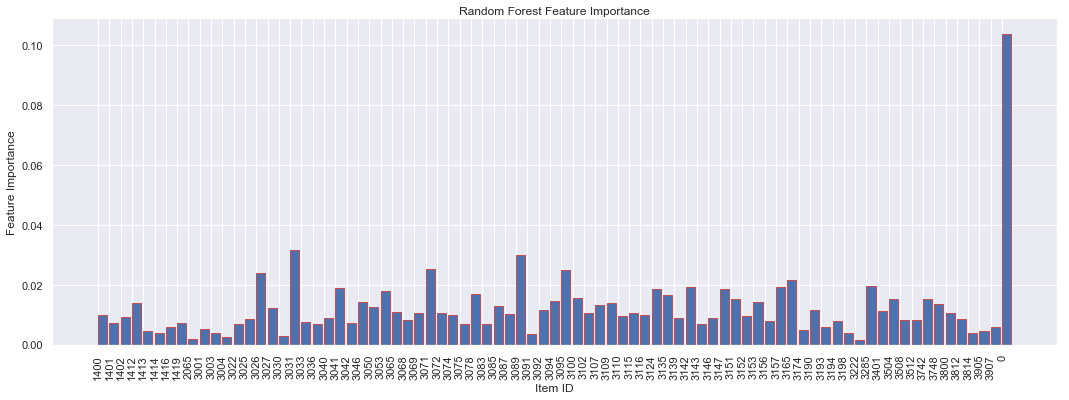

In [115]:
plt.rcParams["figure.figsize"] = (18, 6)
_ = plt.bar(range(len(gs_forest_1.best_estimator_.feature_importances_)),
            gs_forest_1.best_estimator_.feature_importances_,
            edgecolor='r')

items = [str(item) for item in team_items_df.columns.values]
_ = plt.xticks(np.linspace(0, 80, 81), items, rotation=90)
_ = plt.title('Random Forest Feature Importance')
_ = plt.ylabel('Feature Importance')
_ = plt.xlabel('Item ID')
plt.savefig('../analysis_images/rf_feature_importances.png')

Here, we can see that the most important feature by far is the empty item slot (item id = 0).

However, feature importance doesn't tell me which category the feature tends towards. This will be tricky to interpret.

In [48]:
forest_results_df = pd.DataFrame(data=gs_forest_1.best_estimator_.feature_importances_,
                                 columns=['Feature Importance'],
                                 index=team_items_df.columns.values)
forest_results_df = forest_results_df.join(item_occ['name'])
forest_results_df.loc[0, 'name'] = 'Empty'

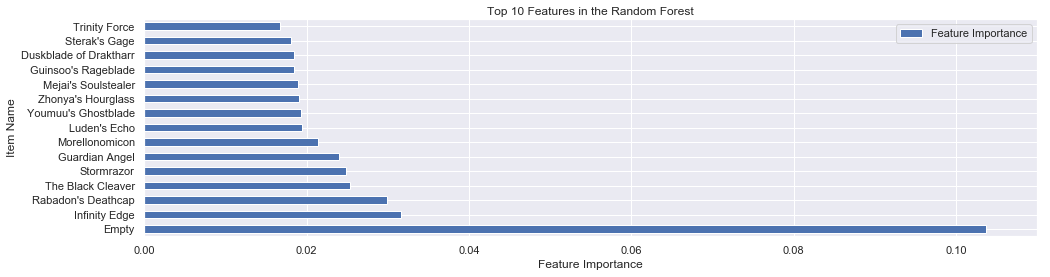

In [49]:
plt.rcParams["figure.figsize"] = (16, 4)
_ = forest_results_df.sort_values('Feature Importance', ascending=False
                                 ).iloc[:15,:].plot(y='Feature Importance', x='name', kind='barh',
                                                    color='b', xlim=[0, 0.11])

_ = plt.xlabel('Feature Importance')
_ = plt.ylabel('Item Name')
_ = plt.title('Top 10 Features in the Random Forest')
plt.savefig('../analysis_images/rf_most_important_features.png')

These are the top 10 features (according to the algorithm). 

This means that having more or less of these 10 items (or lack of item) have the most impact on the result of the game.

However, this plot doesn't indicate if having more of these items will impact make you more or less likely to win. For instance, having more of the Empty item slot on your team definitely decreases your chances of winning, but it the most important feature.

The problem is that just adding one of an item will generally help you win, but this change in win likelihood needs to be compared to a benchmark. We need to know how much better or worse it is to build a given item than any other item.

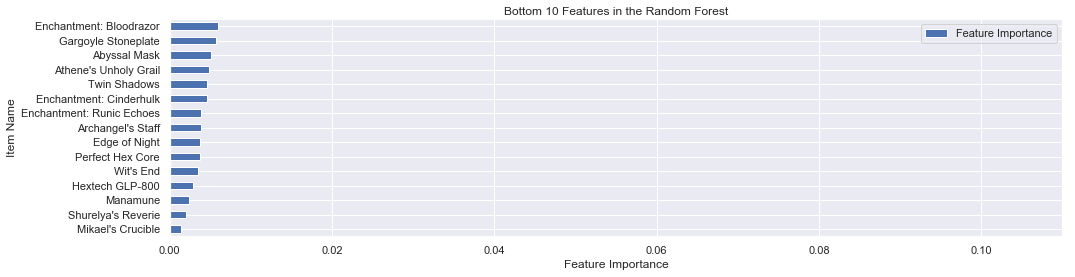

In [50]:
plt.rcParams["figure.figsize"] = (16, 4)
_ = forest_results_df.sort_values('Feature Importance'
                                 ).iloc[:15,:].plot(y='Feature Importance', x='name', kind='barh',
                                                    color='b', xlim=[0, 0.11])

_ = plt.xlabel('Feature Importance')
_ = plt.ylabel('Item Name')
_ = plt.title('Bottom 10 Features in the Random Forest')
plt.savefig('../analysis_images/rf_least_important_features.png')

These are the 10 least importance features.

In [51]:
forest_results_df.sort_values('Feature Importance', ascending=False).iloc[:15,:]

,Feature Importance,name
0,0.103706,Empty
3031,0.031686,Infinity Edge
3089,0.029842,Rabadon's Deathcap
3071,0.025379,The Black Cleaver
3095,0.024824,Stormrazor
3026,0.023970,Guardian Angel
3165,0.021457,Morellonomicon
3285,0.019386,Luden's Echo
3142,0.019308,Youmuu's Ghostblade
3157,0.019101,Zhonya's Hourglass


In [52]:
prediction_test_data = pd.DataFrame(0, index=range(1),
                                    columns=full_items_df.index.values,
                                    dtype=int)
prediction_test_data.loc[0, 0] = 0
prediction_test_data.loc[0, 0] = 0
gs_forest_1.predict_proba(prediction_test_data.values)

array([[ 0.50566667,  0.49433333]])

To evaluate the performance, can I pick 5 items for each player, predict who wins, and then see how the prediction changes if I add / subtract 1 for a given item?

Try the algorithm again without the 0 column

Try a Logistic regression with and without the 0 column

## Logistic Regression

I will use the same data. Let's see it again.

In [53]:
team_items_df.head()

,1400,1401,1402,1412,1413,1414,1416,1419,2065,3001,...,3508,3512,3742,3748,3800,3812,3814,3905,3907,0
0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0
2,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [54]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(team_items_df.values, team_results,
                                                            test_size=0.3,
                                                            random_state=13,
                                                            stratify=team_results)

In [55]:
lr_model = LogisticRegression(random_state=13)
lr_model.fit(X_1_train, y_1_train)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
lr_model.score(X_1_train, y_1_train)

0.91962905718701704

In [57]:
lr_model.score(X_1_test, y_1_test)

0.88848920863309355

Wow! This model has a much better accuracy than the previous. 

I suppose Random Forests are not super accurate, but give a good idea of the important features.

To do some hyperparameter tuning, we can consider the penalty, the regularization strength C, and maybe the intercept (fit_intercept)?

Below is the model's intercept (which should be what it outputs if I give it no data?). I would think that, given an empty matrix of item counts, the model should output a 50/50 chance for either side to win.

In [58]:
lr_model.intercept_

array([ 0.28033277])

In [59]:
lr_model.coef_

array([[ 0.0980002 ,  0.34905936, -0.25290086,  0.39459806,  0.2135976 ,
         0.5191459 ,  0.35484465, -0.31160697,  0.14108985,  0.86528346,
         0.70590727, -0.05656494,  1.11518232,  0.92975683,  0.7658619 ,
         0.69113393,  0.05942467,  1.29569907,  1.25647597,  0.79682886,
         1.00217977,  0.54095208,  0.28209   ,  0.69833598,  1.09795039,
         1.35691736,  0.80979715,  1.06250325,  0.13192074,  0.79614345,
         0.89046008,  0.9278439 ,  1.04463767,  0.9292695 ,  0.5648618 ,
         0.84287775,  0.96959757,  1.61444515, -0.18502289,  0.35527049,
         0.18562241,  1.05072352,  0.97179722,  1.1940411 ,  0.89789156,
         0.69347775,  0.89420433,  0.77352342,  0.25888616,  1.12743352,
         0.7493776 ,  1.03151347,  0.55808893,  0.78418407,  0.67056858,
         1.10934189,  1.52762438,  0.52301203,  0.96097673,  0.82121645,
         1.05699475,  1.09852057,  0.05039167,  0.98444418,  1.30911745,
         0.58638982,  0.49307434,  0.12655559,  1.0

Interesting. It looks like the last coefficient (Empty item slot) has a strong negative value, but is not the only negative coefficient.

### Logistic Regression Hyperparameter Tuning

Tune the penalty function, the regularization strength C, and using the intercept. Don't know if I should test different solvers.

In [60]:
lr_model_gs = LogisticRegression(random_state=13)

params={'penalty': ['l1', 'l2'],
        'C': [0.1, 1.0, 10, 100],
        'fit_intercept': [True, False]}

lr_gridsearch = GridSearchCV(lr_model_gs, param_grid=params, cv=5)

In [61]:
lr_gridsearch.fit(X_1_train, y_1_train)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10, 100], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
lr_gridsearch.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The best estimator used l2 penalty, C=1.0, and fit_intercept=True, all default settings.

In [63]:
lr_gridsearch.best_score_

0.84853168469860896

In [64]:
lr_gridsearch.cv_results_

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\ut

{'mean_fit_time': array([ 0.00120001,  0.00219998,  0.00119996,  0.00140004,  0.00160007,
         0.0026    ,  0.00179996,  0.00199995,  0.0046    ,  0.00300002,
         0.0046    ,  0.00300002,  0.01239996,  0.00400004,  0.0111999 ,
         0.00419993]),
 'mean_score_time': array([ 0.00279999,  0.        ,  0.        ,  0.00039997,  0.0006    ,
         0.        ,  0.        ,  0.00099998,  0.00040007,  0.00039997,
         0.00019999,  0.00040002,  0.00040007,  0.00260005,  0.00019999,  0.        ]),
 'mean_test_score': array([ 0.71406491,  0.83771252,  0.71251932,  0.83462133,  0.82689335,
         0.84853168,  0.83307573,  0.8438949 ,  0.83462133,  0.83616692,
         0.83771252,  0.84544049,  0.83153014,  0.83153014,  0.82225657,
         0.82534776]),
 'mean_train_score': array([ 0.77201374,  0.89837628,  0.77317279,  0.89180436,  0.92542277,
         0.92928229,  0.92155803,  0.9250322 ,  0.93932317,  0.93816263,
         0.94086981,  0.93778249,  0.93970778,  0.93932243,  

Mean training scores for the cross-validation were between 0.77 and 0.95, skewed heavily towards the latter.

Mean test scores for the cross-validation were between 0.71 and 0.85, skewed heavily towards the latter.

In [65]:
lr_gridsearch.score(X_1_test, y_1_test)

0.88848920863309355

Unsurprisingly, since the best parameters were the default ones, this model performs identically to the stock Logistic Regression model.

Let's look at the coefficients. They are identical to the other model as well. Nice.

In [66]:
lr_gridsearch.best_estimator_.coef_ - lr_model.coef_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

In [67]:
lr_results_df = pd.DataFrame(data=lr_model.coef_[0],
                             columns=['Feature Coefficients'],
                             index=team_items_df.columns.values)
lr_results_df = lr_results_df.join(item_occ['name'])
lr_results_df.loc[0, 'name'] = 'Empty'

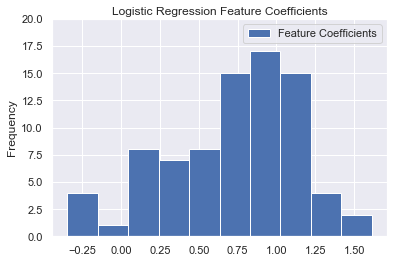

In [118]:
plt.rcParams["figure.figsize"] = (6, 4)
_ = lr_results_df.plot.hist('Feature Coefficients')
_ = plt.title('Logistic Regression Feature Coefficients')
_ = plt.ylim([0, 20])
plt.savefig('../analysis_images/lr_feature_coefs.png')

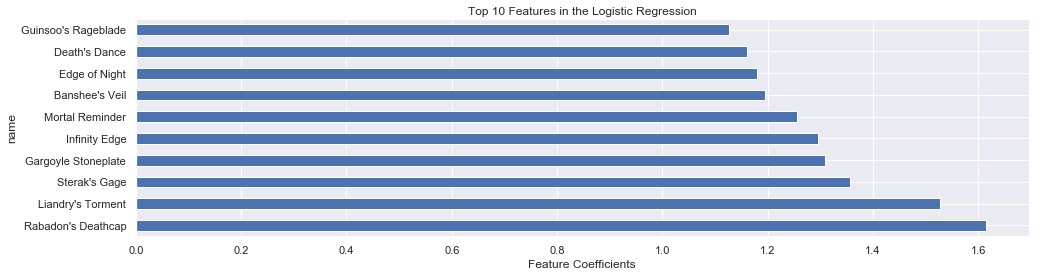

In [69]:
plt.rcParams["figure.figsize"] = (16, 4)
_ = lr_results_df.sort_values('Feature Coefficients', ascending=False
                             ).iloc[0:10, :].plot(y='Feature Coefficients', x='name', kind='barh',
                                                  color='b', legend=False)
_ = plt.title('Top 10 Features in the Logistic Regression')
_ = plt.xlabel('Feature Coefficients')
plt.savefig('../analysis_images/lr_fcoefs_best.png')

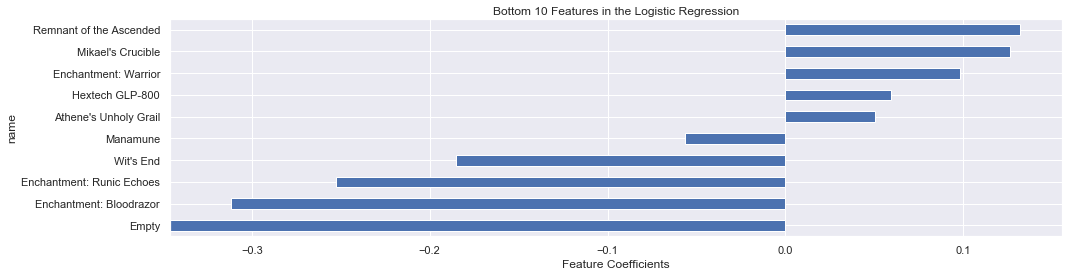

In [70]:
_ = lr_results_df.sort_values('Feature Coefficients', ascending=True
                             ).iloc[0:10, :].plot(y='Feature Coefficients', x='name', kind='barh',
                                                  color='b', legend=False)
_ = plt.title('Bottom 10 Features in the Logistic Regression')
_ = plt.xlabel('Feature Coefficients')
plt.savefig('../analysis_images/lr_fcoefs_worst.png')

So, there are 4 items that this algorithm claims will contribute to losing a game if you buy them.

However, the empty item slot is still the strongest indicator of losing a game.

In [71]:
# Attach Machine Learning results to the item statistics df
item_occ = item_occ.join(forest_results_df.drop('name', axis=1), how='left'
                        ).join(lr_results_df.drop('name', axis=1), how='left')

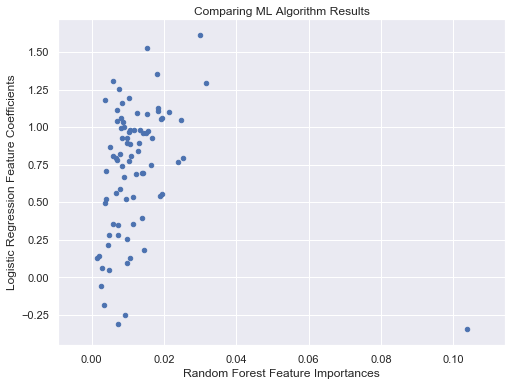

In [72]:
plt.rcParams["figure.figsize"] = (8, 6)
_ = item_occ.plot(x='Feature Importance', y='Feature Coefficients', kind='scatter')
_ = plt.title('Comparing ML Algorithm Results')
_ = plt.ylabel('Logistic Regression Feature Coefficients')
_ = plt.xlabel('Random Forest Feature Importances')
plt.savefig('../analysis_images/ml_model_comparison.png')

The algorithms mostly agree that the items that are important are the items that have a stronger chance to make you win. 

This is to say that there is a strong correlation between items that are more likely to make you win (Logistic Regression Feature Coefficients) and items that were deemed important in the Random Forest (Feature Importances).

In [73]:
# Install a boolean column for visualizations of anomalous items vs the whole
item_occ['Anomalous Win Rate'] = 'blue'
item_occ.loc[(item_occ['full_item'] == True) &
             (no_edge_cases) &
             (item_occ['count_unmasked'] > 10) &
             ((item_occ['wr_unmasked'] - full_item_avg_wr_unmasked).abs() >
              (item_occ['wr_std_unmasked'] * 1.96)), 'Anomalous Win Rate'] = 'red'

In [74]:
item_occ['Anomalous Win Rate'].value_counts()

blue    190
red      18
Name: Anomalous Win Rate, dtype: int64

Here are the anomalous win-rate items (the cyan graph) from earlier, plotted with their Logistic Regression Feature Coefficients

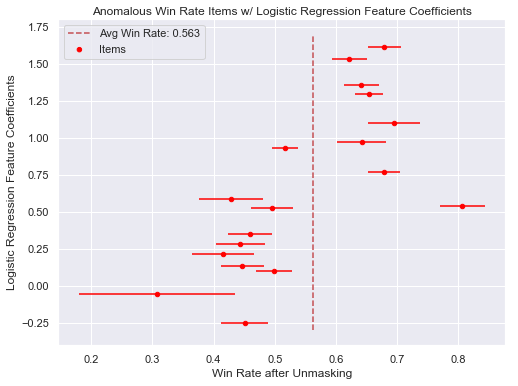

In [75]:
_ = item_occ[(item_occ['full_item'] == True) &
             (no_edge_cases) &
             (item_occ['count_unmasked'] > 10) &
             ((item_occ['wr_unmasked'] - full_item_avg_wr_unmasked).abs() >
              (item_occ['wr_std_unmasked'] * 1.96))].plot(y='Feature Coefficients', x='wr_unmasked',
                                                          kind='scatter', xerr='wr_std_unmasked',
                                                          label='Items', color='red')
_ = plt.plot(np.full(50, full_item_avg_wr_unmasked), np.linspace(-0.30, 1.7, 50), 'r--', label='Avg Win Rate: 0.563')

_ = plt.legend()
_ = plt.title('Anomalous Win Rate Items w/ Logistic Regression Feature Coefficients')
_ = plt.xlabel('Win Rate after Unmasking')
_ = plt.ylabel('Logistic Regression Feature Coefficients')
plt.savefig('../analysis_images/lr_coefs_vs_win_rate_anomalous.png')

For reference, here are the rest of the items. You'll notice they sit much closer to the red line, in general.

I should try to color the anomalous points differently.

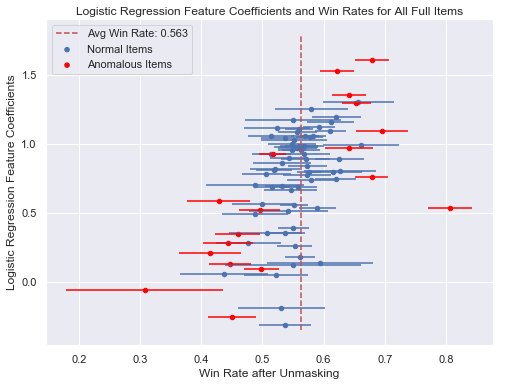

In [76]:
# Set up separate df so the code is cleaner
plotting_df = item_occ[(item_occ['full_item'] == True) &
                       (no_edge_cases) &
                       (item_occ['count_unmasked'] > 10)]
# Set up ax so that I can make multiple plot calls to the same plot
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()

# Data
plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(y='Feature Coefficients', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Normal Items', xerr='wr_std_unmasked', color='b')
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(y='Feature Coefficients', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Anomalous Items', xerr='wr_std_unmasked', color='red')
# Avg Win Rate Line
plt.plot(np.full(50, full_item_avg_wr_unmasked), np.linspace(-0.35, 1.8, 50), 'r--', label='Avg Win Rate: 0.563')

plt.legend()
plt.title('Logistic Regression Feature Coefficients and Win Rates for All Full Items')
plt.xlabel('Win Rate after Unmasking')
plt.ylabel('Logistic Regression Feature Coefficients')
plt.savefig('../analysis_images/lr_coefs_vs_win_rate_all.png')
plt.show()

This result is pretty interesting. At first glance, there seems to be an even spread of feature coefficients vs win rate for the anomalous items. However, there does appear to be a correlation between the win rate and the feature coefficient.

Most of the anomalously high win rate items have pretty strong feature coefficients, and most of the anomalously low win rate items have fairly weak feature coefficients (a few below 0, even!).

However, I have another question now. Not all items are supposed to have the same strength. Some items are stronger, but cost more to buy. Let's visualize this.

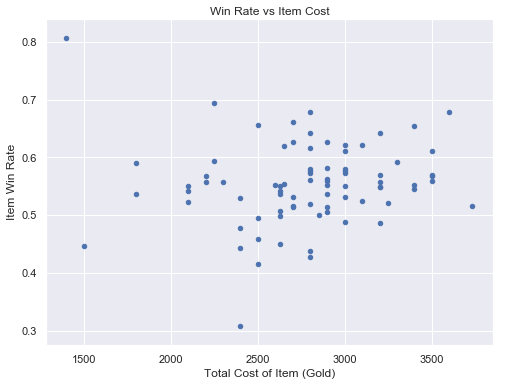

In [77]:
_ = plotting_df.plot('total_gold', 'wr_unmasked', kind='scatter')
_ = plt.xlabel('Total Cost of Item (Gold)')
_ = plt.ylabel('Item Win Rate')
_ = plt.title('Win Rate vs Item Cost')

Win Rate does not have an obvious correlation with item cost.

However, the feature coefficient does correlate with item cost.

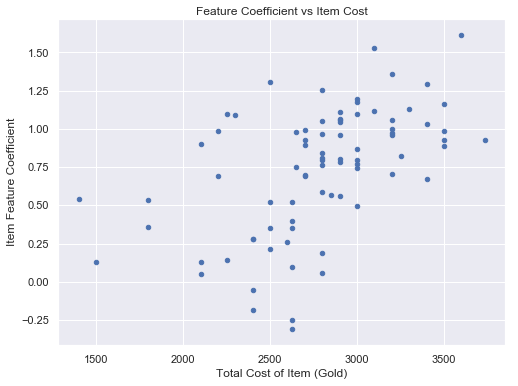

In [78]:
_ = plotting_df.plot('total_gold', 'Feature Coefficients', kind='scatter')
_ = plt.xlabel('Total Cost of Item (Gold)')
_ = plt.ylabel('Item Feature Coefficient')
_ = plt.title('Feature Coefficient vs Item Cost')
plt.savefig('../analysis_images/lr_fcoefs_vs_cost.png')

I want to normalize the Feature Coefficients by the item's cost, then plot that vs win rate.

This is essentially trying to see how much 'bang for your buck' each item has, according to the Logistic Regression.

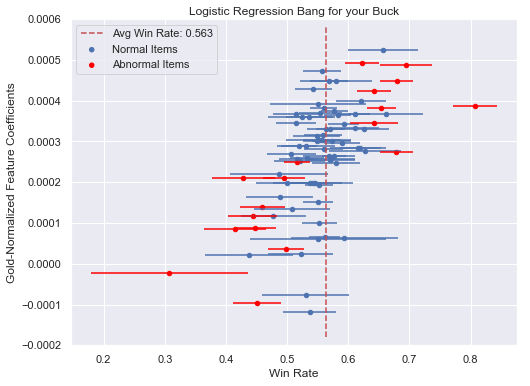

In [79]:
plotting_df.loc[:, 'Gold-Normalized Feature Coefficients'] =\
    plotting_df['Feature Coefficients'] / plotting_df['total_gold']

fig2, ax = plt.subplots()

plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(x='wr_unmasked', y='Gold-Normalized Feature Coefficients', ax=ax,
                       kind='scatter', xerr='wr_std_unmasked', ylim=[-0.0002, 0.0006],
                       color='b', label='Normal Items')

plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(x='wr_unmasked', y='Gold-Normalized Feature Coefficients', ax=ax,
                       kind='scatter', xerr='wr_std_unmasked', ylim=[-0.0002, 0.0006],
                       color='red', label='Abnormal Items')

plt.plot(np.full(50, full_item_avg_wr_unmasked), np.linspace(-0.00018, 0.00058, 50), 'r--', label='Avg Win Rate: 0.563')

plt.title('Logistic Regression Bang for your Buck')
plt.xlabel('Win Rate')
plt.legend()
plt.savefig('../analysis_images/lr_fcoefs_bang_for_buck.png')
plt.show()

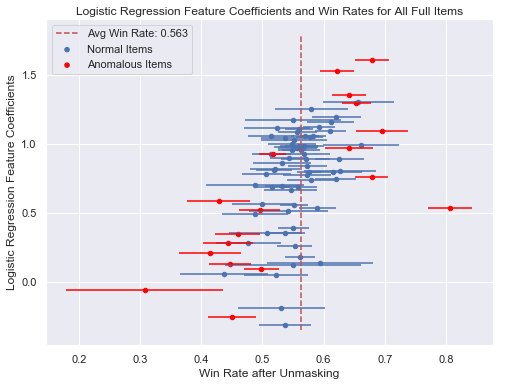

In [80]:
# Compare the gold-normalized plot with the original one
fig

This does not seem too different. I suppose this means that the items' costs are well-balanced.

The most notable outlier (Mejai's Soulstealer, with a post-unmasking win rate of > 0.8), seems not very important to the Logistic Regression. This seems to indicate that the Logistic Regression might favor items that show up more, aka have a large pick rate.

Let's see if this is true.

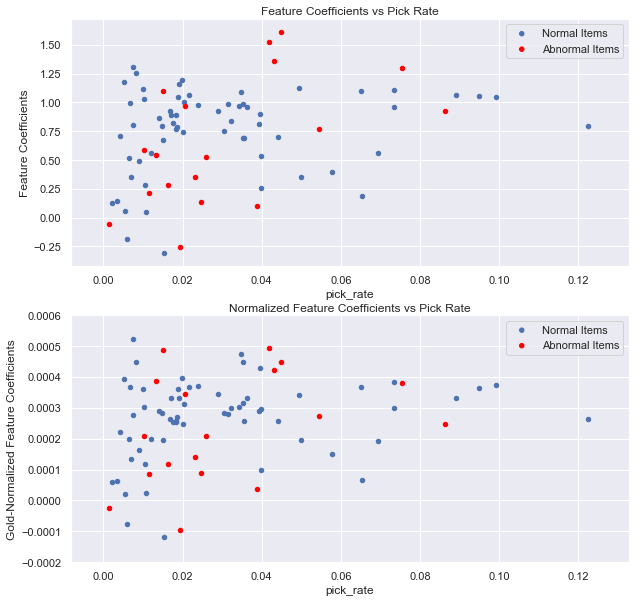

In [81]:
plt.rcParams["figure.figsize"] = (10, 10)
fig3, (ax1, ax2) = plt.subplots(2, 1)

plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(x='pick_rate', y='Feature Coefficients', ax=ax1,
                       kind='scatter',
                       color='b', label='Normal Items')

plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(x='pick_rate', y='Feature Coefficients', ax=ax1,
                       kind='scatter',
                       color='red', label='Abnormal Items')
ax1.set_title('Feature Coefficients vs Pick Rate')

plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(x='pick_rate', y='Gold-Normalized Feature Coefficients', ax=ax2,
                       kind='scatter', ylim=[-0.0002, 0.0006],
                       color='b', label='Normal Items')

plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(x='pick_rate', y='Gold-Normalized Feature Coefficients', ax=ax2,
                       kind='scatter', ylim=[-0.0002, 0.0006],
                       color='red', label='Abnormal Items')

ax2.set_title('Normalized Feature Coefficients vs Pick Rate')
plt.show()

We can see that there is a slight correlation betwen Feature Coefficients and Pick Rate.

In [82]:
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
           ][['name', 'wr_unmasked', 'Feature Coefficients']].sort_values('Feature Coefficients', ascending=False)

,name,wr_unmasked,Feature Coefficients
item_id,,,
3089,Rabadon's Deathcap,0.679054,1.614445
3151,Liandry's Torment,0.622074,1.527624
3053,Sterak's Gage,0.641638,1.356917
3031,Infinity Edge,0.653753,1.295699
3050,Zeke's Convergence,0.694915,1.097950
3087,Statikk Shiv,0.641892,0.969598
3078,Trinity Force,0.516667,0.929270
3026,Guardian Angel,0.678457,0.765862
3194,Adaptive Helm,0.428571,0.586390


I should check and make sure I understand what the Logistic Regression Coefficients mean.

If I give the model an array of 0s, I expect it predict the intercept.

If I give it all 0s and a 1 in column 3089, I should expect a 1.61?

Feature generation

timing data for each item

Look at confusion matrix

Adjust LR threshold based on confusion matrix

In [83]:
confusion_matrix(y_1_train, lr_model.predict(X_1_train))

array([[291,  27],
       [ 25, 304]], dtype=int64)

In [84]:
confusion_matrix(y_1_test, lr_model.predict(X_1_test))

array([[115,  21],
       [ 10, 132]], dtype=int64)

In [85]:
confusion_matrix(y_1_train, lr_gridsearch.predict(X_1_train))

array([[291,  27],
       [ 25, 304]], dtype=int64)

In [86]:
confusion_matrix(y_1_test, lr_gridsearch.predict(X_1_test))

array([[115,  21],
       [ 10, 132]], dtype=int64)

This indicates that the amount of false positives (0,1) is about twice the number of false negatives (1,0).

So, I should increase the threshold slightly, so I guess negative more.

### Logistic Regression Round 2

The intercept doesn't make any sense, and the biggest predictor of a match's result is how many empty item slots each team has.

I want to run the algorithm again without the empty item column. This should improve the model's gauging of individual items, maybe at the expense of prediction accuracy. 

It should also allow me to set the intercept to be something meaningful.

In [87]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(team_items_df.drop(0, axis=1).values,
                                                            team_results,
                                                            test_size=0.3,
                                                            random_state=13,
                                                            stratify=team_results)

In [88]:
lr_model_no_0 = LogisticRegression(random_state=13)

In [89]:
lr_model_no_0.fit(X_2_train, y_2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
lr_model_no_0.score(X_2_train, y_2_train)

0.90571870170015456

In [91]:
lr_model_no_0.score(X_2_test, y_2_test)

0.8848920863309353

The model performs similarly to it's predecessor, who had access to empty item slot counts.

The intercept still doesn't make sense, though.

From the line below, predicting a game with all 0s for each item shows a 55.8% win chance for team 1. This probability should be 50%.

In [92]:
lr_model_no_0.intercept_

array([ 0.23509646])

In [93]:
lr_model_no_0.predict_proba(np.zeros(80).reshape(1,-1))

array([[ 0.4414951,  0.5585049]])

In [94]:
lr_model_no_intercept = LogisticRegression(random_state=13, fit_intercept=False)
lr_model_no_intercept.fit(X_2_train, y_2_train)
lr_model_no_intercept.intercept_

0.0

In [95]:
lr_model_no_intercept.score(X_2_train, y_2_train)

0.89799072642967548

In [96]:
lr_model_no_intercept.score(X_2_test, y_2_test)

0.88129496402877694

In [97]:
lr_model_no_intercept.predict_proba(np.zeros(80).reshape(1,-1))

array([[ 0.5,  0.5]])

Disabling the intercept gets me the probabilities I want (50/50) for the empty input.

I think, then, that setting 'intercept_scaling' is similar to changing the threshold?

Okay, now we can tune the hyperparameters for this Logistic Regression.

In [98]:
lr_gs_no_intercept = LogisticRegression(random_state=13, fit_intercept=False)

params={'penalty': ['l1', 'l2'],
        'C': [0.1, 1.0, 10, 100]}

lr_gridsearch_no_int = GridSearchCV(lr_gs_no_intercept, param_grid=params, cv=5)

In [99]:
lr_gridsearch_no_int.fit(X_2_train, y_2_train)

C:\Users\sebia\Miniconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The gridsearch found the best parameters to be C = 1.0 and a penalty of L2, the default options again.

In [100]:
lr_gridsearch_no_int.score(X_2_test, y_2_test)

0.87769784172661869

All prediction accuracies are still in the high 80%s, which is good.

Let's look at the results.

In [101]:
lr_results_no_int = pd.DataFrame(data=lr_model_no_intercept.coef_[0],
                                 columns=['Feature Coefficients no Intercept'],
                                 index=team_items_df.drop(0, axis=1).columns.values)
lr_results_no_int = lr_results_no_int.join(item_occ['name'], how='left')

In [102]:
item_occ = item_occ.join(lr_results_no_int.drop('name', axis=1), how='left')

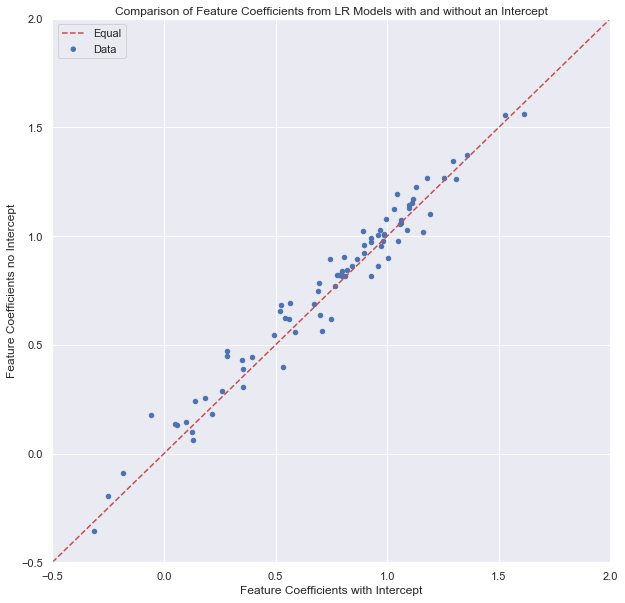

In [103]:
_ = item_occ.plot(x='Feature Coefficients', y='Feature Coefficients no Intercept',
                  kind='scatter', label='Data', xlim=[-0.5, 2.0], ylim=[-0.5, 2.0])
_ = plt.plot(np.linspace(-0.50, 2.0, 50), np.linspace(-0.50, 2.0, 50), 'r--', label='Equal')
_ = plt.title('Comparison of Feature Coefficients from LR Models with and without an Intercept')
_ = plt.legend()
_ = plt.xlabel('Feature Coefficients with Intercept')
plt.savefig('../analysis_images/lr_fcoefs_comparison.png')

This plot compares the feature coefficients from Logistic Regression models fit with and without an intercept.

If a dot is on the red line, then the coefficient didn't change from one model to the other. 

If a dot is below the red line, then the coefficient decreased from the model with the intercept to the model without.

If a dot is above the red line, then the coefficient increased from the model with the intercept to the model without.

It seems like most coefficients went up a bit.

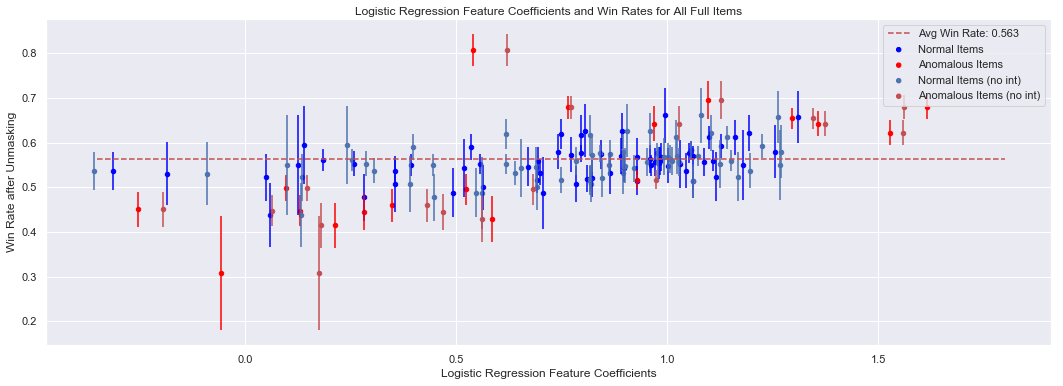

In [104]:
# Set up separate df so the code is cleaner
plotting_df = item_occ[(item_occ['full_item'] == True) &
                       (no_edge_cases) &
                       (item_occ['count_unmasked'] > 10)]
# Set up ax so that I can make multiple plot calls to the same plot
plt.rcParams["figure.figsize"] = (18, 6)
fig, ax = plt.subplots()

# Data
plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(x='Feature Coefficients', y='wr_unmasked', ax=ax,
                     kind='scatter', label='Normal Items', yerr='wr_std_unmasked', color='blue')
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(x='Feature Coefficients', y='wr_unmasked', ax=ax,
                     kind='scatter', label='Anomalous Items', yerr='wr_std_unmasked', color='red')
plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(x='Feature Coefficients no Intercept', y='wr_unmasked', ax=ax,
                     kind='scatter', label='Normal Items (no int)', yerr='wr_std_unmasked', color='b')
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(x='Feature Coefficients no Intercept', y='wr_unmasked', ax=ax,
                     kind='scatter', label='Anomalous Items (no int)', yerr='wr_std_unmasked', color='r')
# Avg Win Rate Line
plt.plot(np.linspace(-0.35, 1.8, 50), np.full(50, full_item_avg_wr_unmasked), 'r--', label='Avg Win Rate: 0.563')

plt.legend()
plt.title('Logistic Regression Feature Coefficients and Win Rates for All Full Items')
plt.ylabel('Win Rate after Unmasking')
plt.xlabel('Logistic Regression Feature Coefficients')
plt.show()

The plot of all the coefficients is a bit much to look at.

Look at the distribution of new coefficients.

Looking at the change in coefficients, it seems like none of them changed too much.

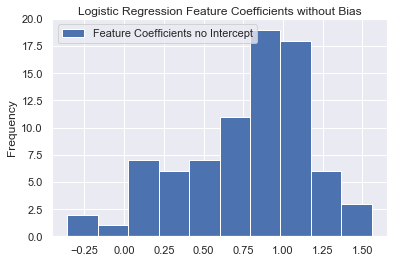

In [117]:
plt.rcParams["figure.figsize"] = (6, 4)
_ = plotting_df[['Feature Coefficients no Intercept']].plot.hist('Feature Coefficients (no Intercept)')
_ = plt.title('Logistic Regression Feature Coefficients without Bias')
_ = plt.ylim([0, 20])
plt.savefig('../analysis_images/lr_feature_coefs_sans_bias.png')

C:\Users\sebia\Miniconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sebia\Miniconda2\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(50, 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


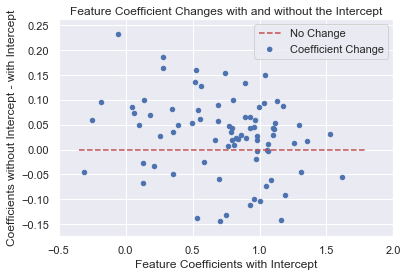

In [106]:
plotting_df['Feature Coef Difference'] = plotting_df['Feature Coefficients no Intercept'] -\
                                         plotting_df['Feature Coefficients']
_ = plotting_df.plot(y='Feature Coef Difference', x='Feature Coefficients',
                     kind='scatter', label='Coefficient Change', xlim=[-0.5, 2.0])
_ = plt.plot(np.linspace(-0.35, 1.8, 50), np.full(50, 0), 'r--', label='No Change')
_ = plt.title('Feature Coefficient Changes with and without the Intercept')
_ = plt.xlabel('Feature Coefficients with Intercept')
_ = plt.ylabel('Coefficients without Intercept - with Intercept')
_ = plt.legend()
plt.savefig('../analysis_images/lr_fcoef_changes.png')

The overall distribution of Feature Coefficients and Win Rates looks pretty similar with and without the intercept in the Logistic Regression model.

There might be a slight correlation, indicating that removing the intercept tended to increase small feature coefficients more than large feature coefficients.

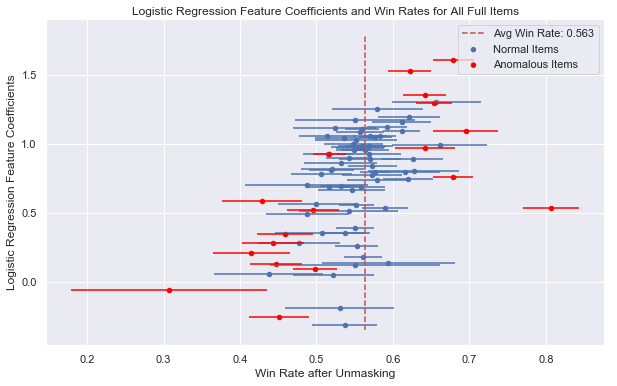

In [107]:
plt.rcParams["figure.figsize"] = (10, 6)
fig, ax = plt.subplots()

# Data
plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(y='Feature Coefficients', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Normal Items', xerr='wr_std_unmasked', color='b')
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(y='Feature Coefficients', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Anomalous Items', xerr='wr_std_unmasked', color='red')
# Avg Win Rate Line
plt.plot(np.full(50, full_item_avg_wr_unmasked), np.linspace(-0.35, 1.8, 50), 'r--', label='Avg Win Rate: 0.563')

plt.legend()
plt.title('Logistic Regression Feature Coefficients and Win Rates for All Full Items')
plt.xlabel('Win Rate after Unmasking')
plt.ylabel('Logistic Regression Feature Coefficients')
plt.show()

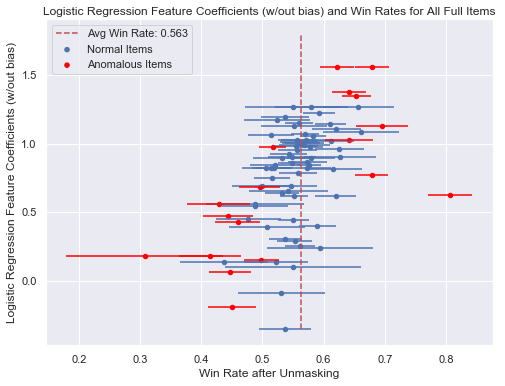

In [108]:
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots()

# Data
plotting_df[plotting_df['Anomalous Win Rate'] == 'blue'
                ].plot(y='Feature Coefficients no Intercept', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Normal Items', xerr='wr_std_unmasked', color='b')
plotting_df[plotting_df['Anomalous Win Rate'] == 'red'
                ].plot(y='Feature Coefficients no Intercept', x='wr_unmasked', ax=ax,
                     kind='scatter', label='Anomalous Items', xerr='wr_std_unmasked', color='red')
# Avg Win Rate Line
plt.plot(np.full(50, full_item_avg_wr_unmasked), np.linspace(-0.35, 1.8, 50), 'r--', label='Avg Win Rate: 0.563')

plt.legend()
plt.title('Logistic Regression Feature Coefficients (w/out bias) and Win Rates for All Full Items')
plt.xlabel('Win Rate after Unmasking')
plt.ylabel('Logistic Regression Feature Coefficients (w/out bias)')
plt.savefig('../analysis_images/lr_fcoefs_vs_win_rate_sans_bias.png')
plt.show()

## Recommendations: What to Change

There are 4 sets of suspect items.

Items that have statistically high / low win rates compared to the mean.

Items that have logistic regression feature coefficients that are rather high / low (taking top / bottom 10).

The intersection of the unusually high-valued sets is a good first pass, and their union is a good second pass for what to nerf.

The intersection of the unusually low-valued sets is a good first pass, and their union is a good second pass for what to buff.

Jungle items should be manually checked, since their win rates do not sit around the average from the rest of the items.

### Too Weak

From the Logistic Regression

In [109]:
plotting_df.sort_values('Feature Coefficients no Intercept')[[
    'name', 'Feature Coefficients no Intercept', 'wr_unmasked', 'wr_std_unmasked'
]].head(10)

,name,Feature Coefficients no Intercept,wr_unmasked,wr_std_unmasked
item_id,,,,
1419,Enchantment: Bloodrazor,-0.357105,0.536765,0.042759
1402,Enchantment: Runic Echoes,-0.193140,0.450617,0.039092
3091,Wit's End,-0.089383,0.530612,0.071295
3069,Remnant of the Ascended,0.064347,0.447115,0.034474
3222,Mikael's Crucible,0.099733,0.550000,0.111243
3030,Hextech GLP-800,0.133061,0.437500,0.071603
3174,Athene's Unholy Grail,0.136775,0.522222,0.052653
1400,Enchantment: Warrior,0.147085,0.498305,0.029111
3004,Manamune,0.176625,0.307692,0.128008


Checking the red / blue counterparts of the jungle items in this list.

Most jungle items probably shouldn't have been flagged by the win rate statistical analysis.

I have no idea why 1419 has such a low Feature Coefficient compared to 1416, especially with a higher win rate.

1402 has a significantly lower win rate than 1414, so I believe that should be made stronger.

In [110]:
plotting_df[plotting_df['name'].str.contains('Bloodrazor')][[
    'name', 'wr_unmasked', 'Feature Coefficients no Intercept'
]]

,name,wr_unmasked,Feature Coefficients no Intercept
item_id,,,
1416,Enchantment: Bloodrazor,0.507692,0.390567
1419,Enchantment: Bloodrazor,0.536765,-0.357105


In [111]:
plotting_df[plotting_df['name'].str.contains('Runic Echoes')][[
    'name', 'wr_unmasked', 'Feature Coefficients no Intercept'
]]

,name,wr_unmasked,Feature Coefficients no Intercept
item_id,,,
1402,Enchantment: Runic Echoes,0.450617,-0.193140
1414,Enchantment: Runic Echoes,0.542373,0.654774


From the win rate statistical analysis

In [112]:
abnormal_items_um[8:]

item_id
3078                Trinity Force
1400         Enchantment: Warrior
3152         Hextech Protobelt-01
1401      Enchantment: Cinderhulk
1402    Enchantment: Runic Echoes
3069      Remnant of the Ascended
3042                     Muramana
3194                Adaptive Helm
1413      Enchantment: Cinderhulk
3004                     Manamune
Name: name, dtype: object

The intersection of these two lists is:

Runic Echoes (blue)

Remnant of the Ascended

Warrior (blue)

Manamune

Cinderhulk (red)

But Warrior (blue) is probably okay, since it's win rate isn't actually that bad.

### Too Strong

From the Logistic Regression

In [113]:
plotting_df.sort_values('Feature Coefficients no Intercept', ascending=False)[[
    'name', 'Feature Coefficients no Intercept', 'wr_unmasked', 'wr_std_unmasked'
]].head(10)

,name,Feature Coefficients no Intercept,wr_unmasked,wr_std_unmasked
item_id,,,,
3089,Rabadon's Deathcap,1.559884,0.679054,0.027135
3151,Liandry's Torment,1.558140,0.622074,0.028041
3053,Sterak's Gage,1.373923,0.641638,0.028014
3031,Infinity Edge,1.344633,0.653753,0.023411
3033,Mortal Reminder,1.269090,0.579710,0.059423
3814,Edge of Night,1.267040,0.550000,0.078661
3193,Gargoyle Stoneplate,1.263636,0.656716,0.058007
3124,Guinsoo's Rageblade,1.225380,0.592179,0.025973
3075,Thornmail,1.195582,0.536585,0.038939


From the win rate statistical analysis

In [114]:
abnormal_items_um[0:8]

item_id
3041    Mejai's Soulstealer
3050     Zeke's Convergence
3089     Rabadon's Deathcap
3026         Guardian Angel
3031          Infinity Edge
3087           Statikk Shiv
3053          Sterak's Gage
3151      Liandry's Torment
Name: name, dtype: object

The intersection of these lists is 

Rabadon's Deathcap

Liandry's Torment

Sterak's Gage

Infinity Edge